In [1]:
import os
import numpy as np
import warnings
warnings.simplefilter('ignore')

#os.chdir('../')
from lib.methods import *
from lib.functions import *

os.chdir('../')

2023-05-06 00:49:48.360764: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import matplotlib.pylab as plt

In [3]:
class Figure():

    def __init__(self, rcParams_dict):
        for key in rcParams_dict.keys():
            plt.rcParams[str(key)] = rcParams_dict[str(key)]      

    def timeseries(self, 
                data, t, start=0, stop=None,
                figsize=(20, 5), linestyle='-', c='k', lw='3',
                title=None, title_loc='center', 
                xlabel='Time', ylabel=r'$x(t)$',
                save_png=None, save_eps=None):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()
        ax.set_title(title, loc=title_loc)
        ax.plot(t[start:stop], data[start:stop], linestyle=linestyle, c=c, lw=lw)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        plt.tight_layout()
        if save_png==None:
            plt.show()
        else:
            plt.savefig(save_png+'.png', bbox_inches="tight")
        if save_png==None:
            return
        else:
            plt.savefig(save_eps+'.eps', bbox_inches="tight")

    def td_attractor_2d(self, 
                data, n_shift='Auto', start=0, stop=None,
                figsize=(5.5, 5), linestyle='-', c='k', lw='2',
                title=None, title_loc='center', 
                xlabel=r'$x(t)$', ylabel=r'$x(t-\tau)$',
                save_png=None, save_eps=None):
        if n_shift=='Auto':
            tde = TimeDelayEmbedding(data, 1000)
            _, n_shift = tde.mutual_information()
            print('n_shift: '+str(n_shift))
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()
        ax.set_title(title, loc=title_loc)
        ax.plot(data[start:stop][n_shift:], data[start:stop][:-n_shift], linestyle=linestyle, c=c, lw=lw)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_aspect('equal', 'datalim')
        plt.tight_layout()
        if save_png==None:
            plt.show()
        else:
            plt.savefig(save_png+'.png', bbox_inches="tight")
        if save_png==None:
            return
        else:
            plt.savefig(save_eps+'.eps', bbox_inches="tight")

    def power_spectra(self, 
                data, t, freq_lim=(0, 600),
                figsize=(8, 5), linestyle='-', c='k', lw='3',
                title=None, title_loc='center', 
                xlabel='Frequency [Hz]', ylabel='Power Spectral',
                save_png=None, save_eps=None):
        freq_data, amp_data = fft(data, t)
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()
        ax.set_title(title, loc=title_loc)
        ax.plot(freq_data, amp_data, linestyle=linestyle, lw=lw, c=c)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xlim(freq_lim)
        plt.tight_layout()
        if save_png==None:
            plt.show()
        else:
            plt.savefig(save_png+'.png', bbox_inches="tight")
        if save_png==None:
            return
        else:
            plt.savefig(save_eps+'.eps', bbox_inches="tight")


In [4]:
class MRI8_NVF4_10mm_0p2mmVVV:
    CSV_FILE_DIR = './data/VF_FVF_DATASETS/CSV/'
    VIDEO_FILE_DIR = './data/VF_FVF_DATASETS/VIDEO/'
    DATA_NAME = 'MRI8_NVF4_10mm_0p2mmVVV'
    SAMPLE_SPAN = [150000, 170000]
    FILTERING_CSV_METHODS = 'bandpass_filtering'
    BANDPASS_FILTERING_PARAMS = {
                    'passband_edge_freq':[100, 350], 
                    'stopband_edge_freq':[20, 800], 
                    'passband_edge_max_loss':1, 
                    'stopband_edge_min_loss':40
                    }
    LINE_SCANNING_PARAMS_VF = {'position':[50, 40],'width': 40}
    LINE_SCANNING_PARAMS_FVF = {'position':[70, 80],'width': 70}
    FILTERING_VIDEO_PARAMS_VF = {'kernel_length':10, 'kernel_size':3}
    FILTERING_VIDEO_PARAMS_FVF = {'kernel_length':10, 'kernel_size':3}

cfg = MRI8_NVF4_10mm_0p2mmVVV

In [5]:
csv_data_list, video_data_list, video_t_data_list = LoadCSVandVIDEOS(
                                                                    csv_path=cfg.CSV_FILE_DIR+cfg.DATA_NAME+'.csv', 
                                                                    data_name_list=['t', 'mic', 'flow'], 
                                                                    sample_span=cfg.SAMPLE_SPAN, 
                                                                    videos_path_list=[
                                                                                    cfg.VIDEO_FILE_DIR+'VF/'+cfg.DATA_NAME+'.avi',
                                                                                    cfg.VIDEO_FILE_DIR+'FVF/'+cfg.DATA_NAME+'.avi',
                                                                                    ]
                                                                    )

mic_t_data = csv_data_list[0]
mic_data = csv_data_list[1]
flow_data = csv_data_list[2]
video_vf_data = video_data_list[0]
video_fvf_data = video_data_list[1]
video_t_data = video_t_data_list[0]

Loading csv data
file path | ./data/VF_FVF_DATASETS/CSV/MRI8_NVF4_10mm_0p2mmVVV.csv
data list | t, mic, flow
Loading video data
file path | ./data/VF_FVF_DATASETS/VIDEO/VF/MRI8_NVF4_10mm_0p2mmVVV.avi


Loading video data
file path | ./data/VF_FVF_DATASETS/VIDEO/FVF/MRI8_NVF4_10mm_0p2mmVVV.avi


In [6]:
pp = PreProcessing(
                data=mic_data,
                t_data=mic_t_data,
                video_data_list=video_data_list, 
                video_t_data_list=video_t_data_list
                )
pp.filter(
        method=cfg.FILTERING_CSV_METHODS, 
        params=cfg.BANDPASS_FILTERING_PARAMS
        )
pp.cut(sample_span=(5000, 15000))
mic_data = pp.data
mic_t_data = pp.t_data
video_vf_data =  pp.video_data_list[0]
video_fvf_data =  pp.video_data_list[1]
video_vf_t_data = pp.video_t_data_list[0]
video_fvf_t_data = pp.video_t_data_list[1]

pp = PreProcessing(
                data=flow_data,
                t_data=mic_t_data,
                video_data_list=[], 
                video_t_data_list=[]
                )
pp.cut(sample_span=(5000, 15000))
flow_data = pp.data

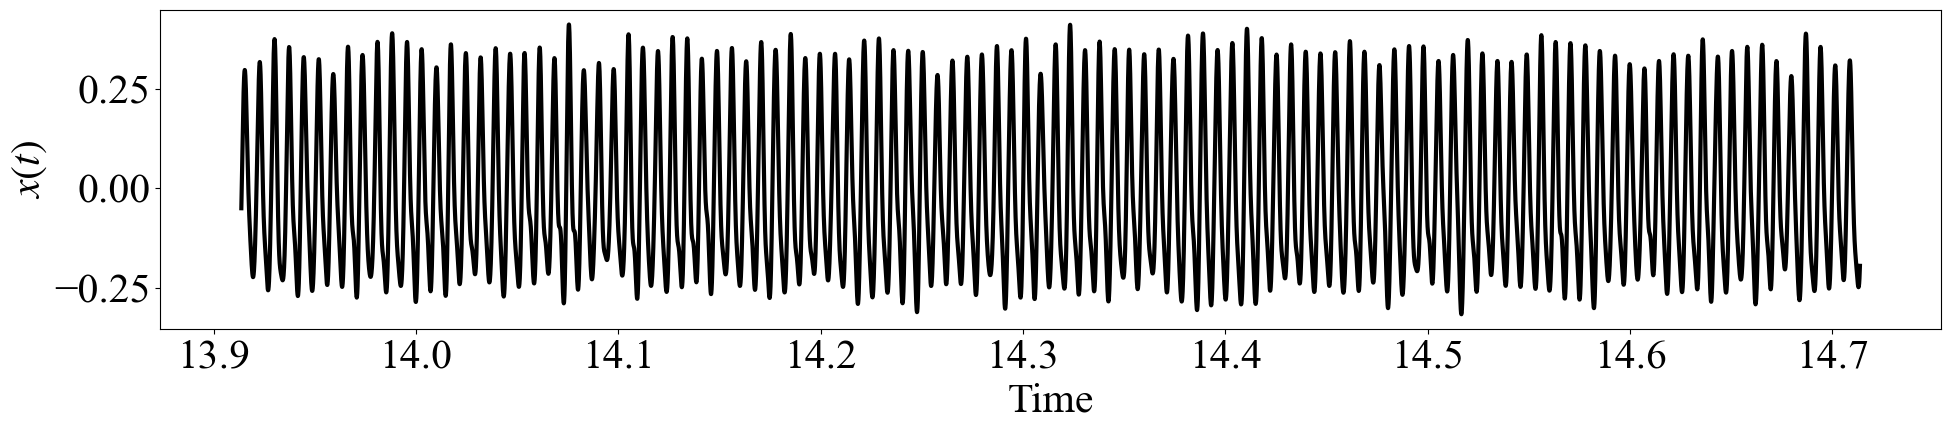

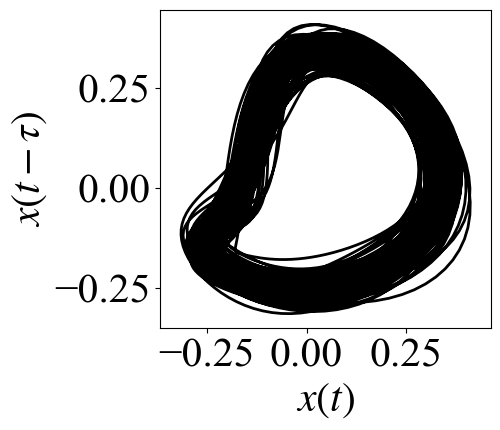

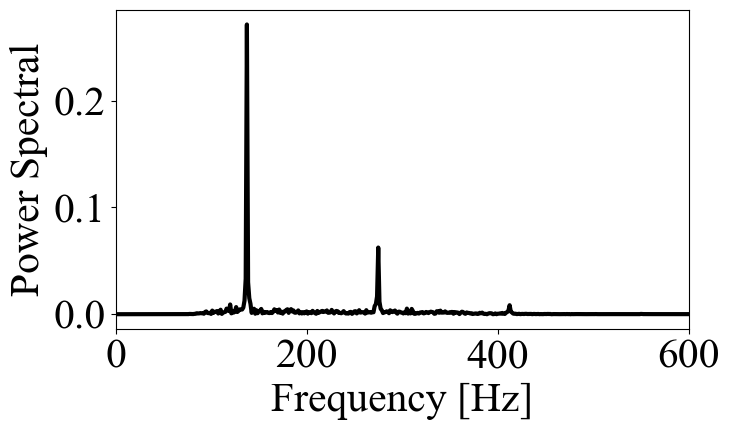

In [7]:
fig = Figure({
            'font.family':'Times New Roman',
            'mathtext.fontset':'stix',
            'font.size':30,
            })

fig.timeseries(data=mic_data, t=mic_t_data, start=0, stop=None,
                figsize=(20, 5), linestyle='-', c='k', lw='3',
                title=None, title_loc='center', 
                xlabel='Time', ylabel=r'$x(t)$',
                save_png=None, save_eps=None)

fig.td_attractor_2d(data=mic_data, n_shift=18, start=0, stop=None,
                figsize=(5.5, 5), linestyle='-', c='k', lw='2',
                title=None, title_loc='center', 
                xlabel=r'$x(t)$', ylabel=r'$x(t-\tau)$',
                save_png=None, save_eps=None)

fig.power_spectra(data=mic_data, t=mic_t_data, freq_lim=(0, 600),
                figsize=(8, 5), linestyle='-', c='k', lw='3',
                title=None, title_loc='center', 
                xlabel='Frequency [Hz]', ylabel='Power Spectral',
                save_png=None, save_eps=None)

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def standardization_3d(data):
    (shape0, shape1, shape2) = data.shape
    SS = StandardScaler()
    return (SS.fit_transform(data.reshape(shape0, shape1*shape2))).reshape(shape0, shape1, shape2)

def normalization_3d(data):
    (shape0, shape1, shape2) = data.shape
    MMS = MinMaxScaler()
    return (MMS.fit_transform(data.reshape(shape0, shape1*shape2))).reshape(shape0, shape1, shape2)

In [49]:
video_vf_data_standardized = standardization_3d(data=video_vf_data)
video_fvf_data_standardized = standardization_3d(data=video_fvf_data)

In [9]:
video_vf_data_normalized = normalization_3d(data=video_vf_data)
video_fvf_data_normalized = normalization_3d(data=video_fvf_data)

#video_vf_data_standardized = standardization_3d(data=video_vf_data_normalized)
#video_fvf_data_standardized = standardization_3d(data=video_fvf_data_normalized)

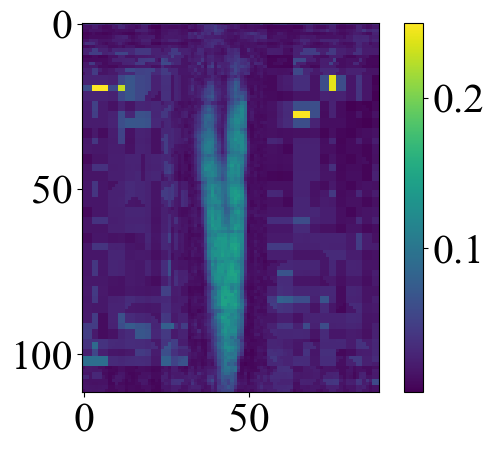

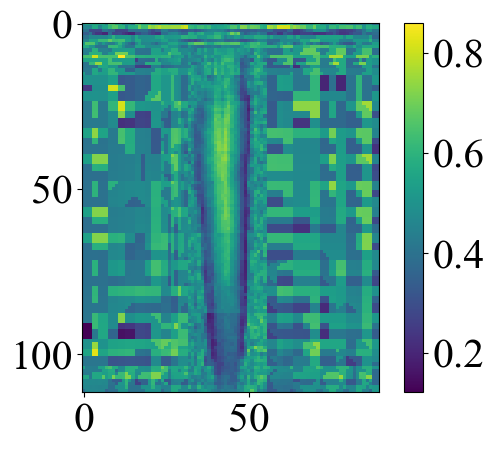

In [66]:
plt.imshow(np.var(video_vf_data_normalized, axis=0))
plt.colorbar()
plt.show()

plt.imshow(np.mean(video_vf_data_normalized, axis=0))
plt.colorbar()
plt.show()

In [19]:
(shape0_vf, shape1_vf, shape2_vf) = video_vf_data_normalized.shape


AE_vf = AutoEncoder(data=video_vf_data_normalized.reshape(shape0_vf, shape1_vf*shape2_vf), 
                    method='PCA', 
                    params_pca={'n_principal_components':10})
### TRAIN MLP
AE_vf.fit(video_vf_data_normalized.reshape(shape0_vf, shape1_vf*shape2_vf))
variance_ratios = AE_vf.variance_ratios
### ENCODE
latent_vector_vf = AE_vf.encode(video_vf_data_normalized.reshape(shape0_vf, shape1_vf*shape2_vf))

In [21]:
latent_vector_vf.shape

(7999, 10)

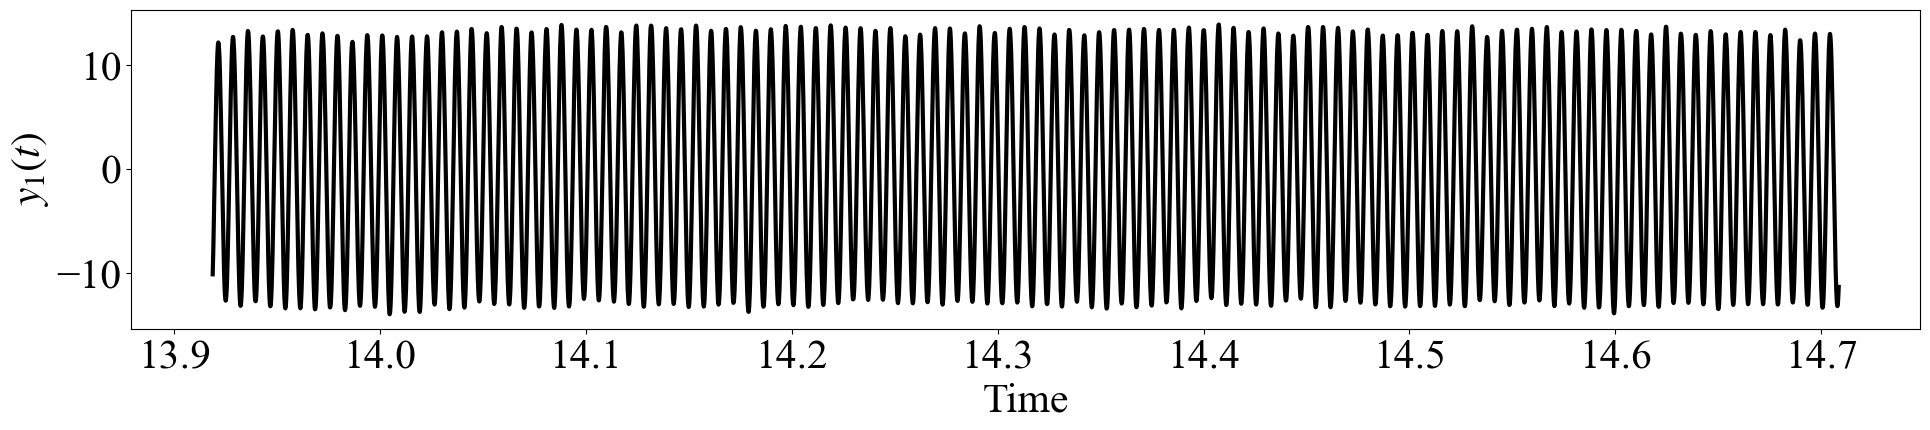

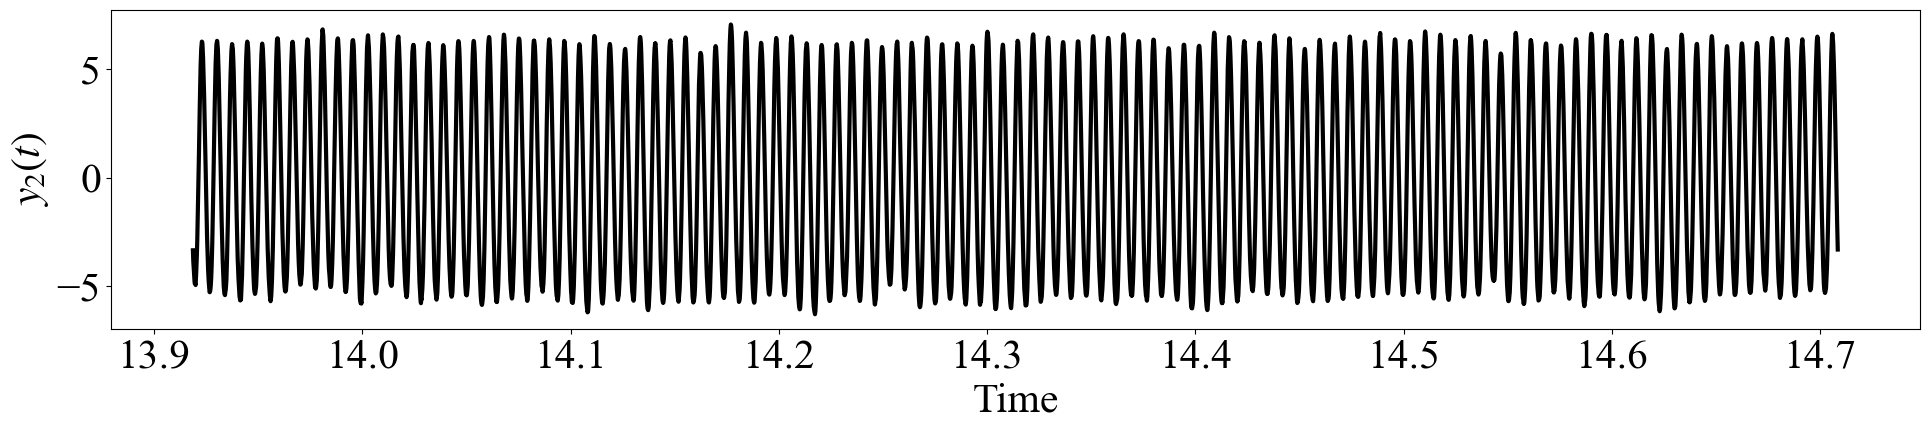

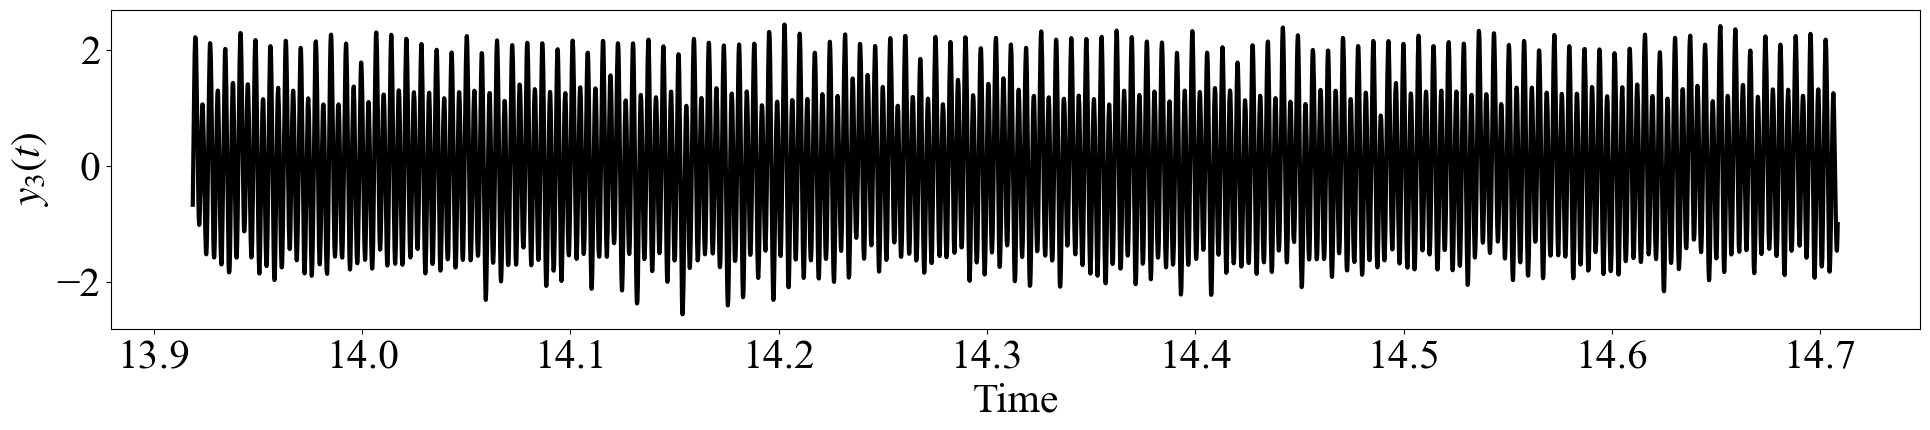

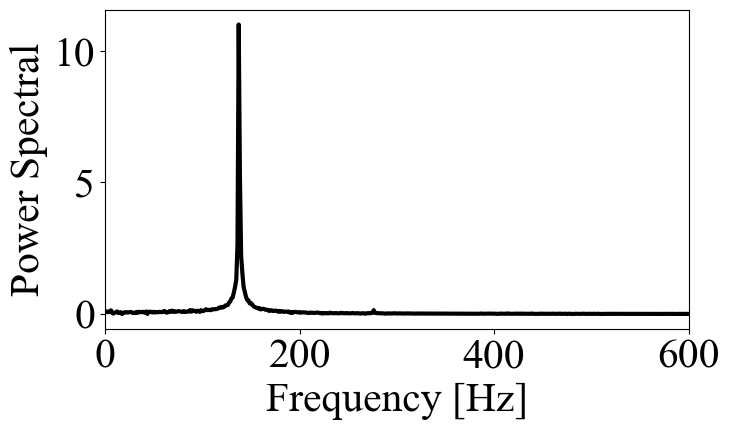

In [145]:
fig = Figure({
            'font.family':'Times New Roman',
            'mathtext.fontset':'stix',
            'font.size':30,
            })

fig.timeseries(data=latent_vector_vf[:, 0], t=video_vf_t_data, start=50, stop=-50,
                figsize=(20, 5), linestyle='-', c='k', lw='3',
                title=None, title_loc='center', 
                xlabel='Time', ylabel=r'$y_1(t)$',
                save_png=None, save_eps=None)
fig.timeseries(data=latent_vector_vf[:, 1], t=video_vf_t_data, start=50, stop=-50,
                figsize=(20, 5), linestyle='-', c='k', lw='3',
                title=None, title_loc='center', 
                xlabel='Time', ylabel=r'$y_2(t)$',
                save_png=None, save_eps=None)
fig.timeseries(data=latent_vector_vf[:, 2], t=video_vf_t_data, start=50, stop=-50,
                figsize=(20, 5), linestyle='-', c='k', lw='3',
                title=None, title_loc='center', 
                xlabel='Time', ylabel=r'$y_3(t)$',
                save_png=None, save_eps=None)      

fig.power_spectra(data=latent_vector_vf[:, 0], t=video_vf_t_data, freq_lim=(0, 600),
                figsize=(8, 5), linestyle='-', c='k', lw='3',
                title=None, title_loc='center', 
                xlabel='Frequency [Hz]', ylabel='Power Spectral',
                save_png=None, save_eps=None)

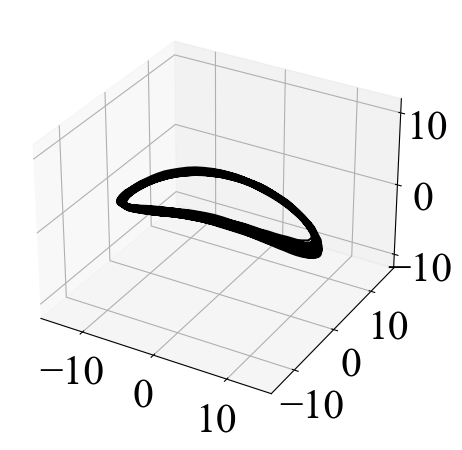

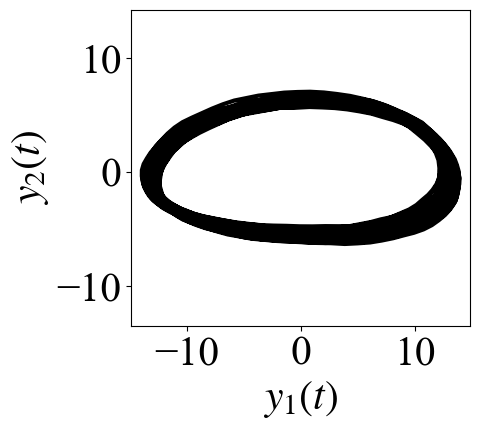

In [49]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(projection='3d')
ax.plot(latent_vector_vf[50:-50, 0], latent_vector_vf[50:-50, 1], latent_vector_vf[50:-50, 2], c='k')
ax.set_aspect('equal', 'datalim')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(5.5, 5))
ax = fig.add_subplot()
ax.plot(latent_vector_vf[50:-50, 0], latent_vector_vf[50:-50, 1], c='k', lw=3)
ax.set_xlabel(r'$y_1(t)$')
ax.set_ylabel(r'$y_2(t)$')
ax.set_aspect('equal', 'datalim')
plt.tight_layout()
plt.show()

In [100]:
import pysindy as ps
train_X = latent_vector_vf[50:-50, :2]
train_t = video_vf_t_data[50:-50]
train_dX = ps.SmoothedFiniteDifference(smoother_kws={'window_length': 5, 'polyorder': 3})._differentiate(x=train_X, t=train_t)
model = ps.SINDy(
                feature_names=['y1', 'y2'], 
                optimizer=ps.STLSQ(threshold=3), 
                feature_library=ps.PolynomialLibrary(degree=5), 
                )
model.fit(x=train_X, 
        t=train_t,  
        x_dot=train_dX)
model.print()

(y1)' = -752.555 1 + 6.217 y1 + -2881.026 y2 + 33.450 y2^2 + 6.050 y1^2 y2 + 26.083 y2^3
(y2)' = -449.209 1 + 398.254 y1 + -16.094 y2 + 5.180 y1^2 + 17.846 y1 y2


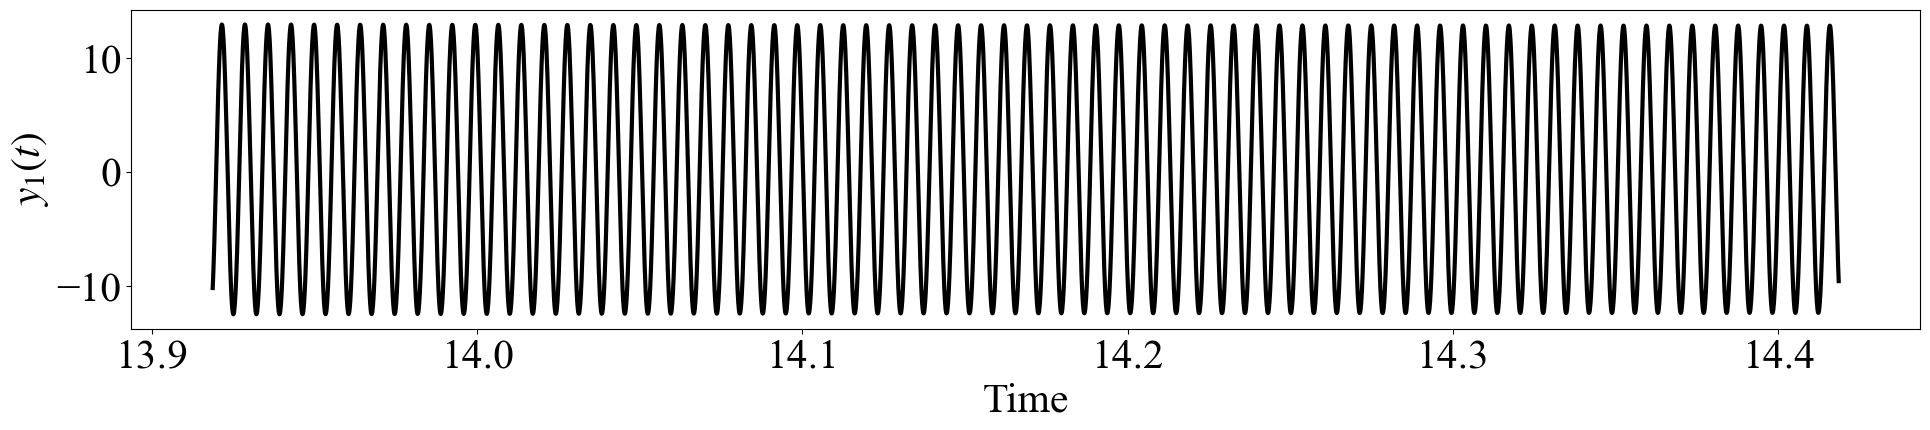

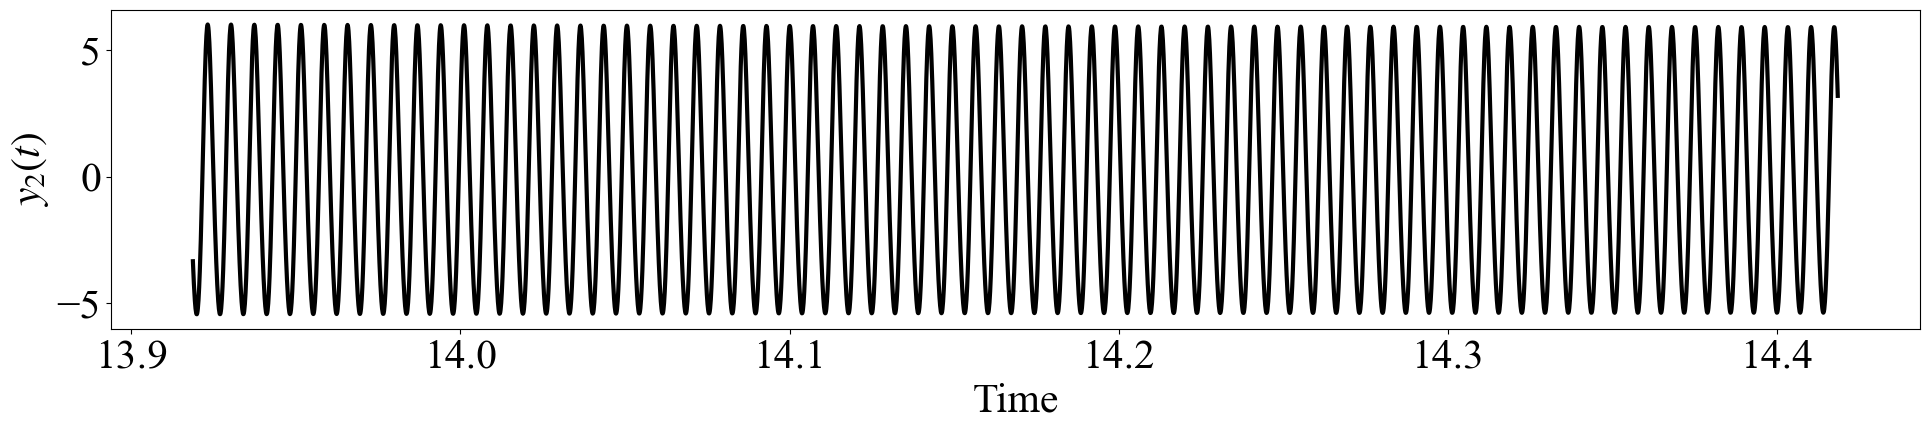

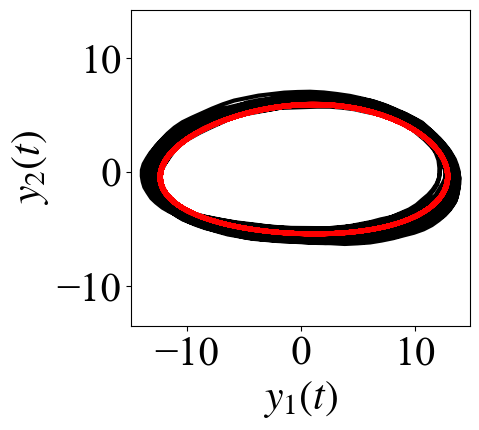

In [103]:
n_run = 5000
pred_train_X = model.simulate(train_X[0, :], train_t[:n_run])
pred_train_X.shape

fig = Figure({
            'font.family':'Times New Roman',
            'mathtext.fontset':'stix',
            'font.size':30,
            })
fig.timeseries(data=pred_train_X[:, 0], t=train_t[:n_run], start=0, stop=None,
                figsize=(20, 5), linestyle='-', c='k', lw='3',
                title=None, title_loc='center', 
                xlabel='Time', ylabel=r'$y_1(t)$',
                save_png=None, save_eps=None)
fig.timeseries(data=pred_train_X[:, 1], t=train_t[:n_run], start=0, stop=None,
                figsize=(20, 5), linestyle='-', c='k', lw='3',
                title=None, title_loc='center', 
                xlabel='Time', ylabel=r'$y_2(t)$',
                save_png=None, save_eps=None)                

fig = plt.figure(figsize=(5.5, 5))
ax = fig.add_subplot()
ax.plot(train_X[:n_run, 0], train_X[:n_run, 1], c='k', lw=3)
ax.plot(pred_train_X[:, 0], pred_train_X[:, 1], c='r', lw=3)
ax.set_xlabel(r'$y_1(t)$')
ax.set_ylabel(r'$y_2(t)$')
ax.set_aspect('equal', 'datalim')
plt.tight_layout()
plt.show()

In [104]:
(shape0_fvf, shape1_fvf, shape2_fvf) = video_fvf_data_normalized.shape


AE_fvf = AutoEncoder(data=video_fvf_data_normalized.reshape(shape0_fvf, shape1_fvf*shape2_fvf), 
                    method='PCA', 
                    params_pca={'n_principal_components':10})
### TRAIN MLP
AE_fvf.fit(video_fvf_data_normalized.reshape(shape0_fvf, shape1_fvf*shape2_fvf))
variance_ratios = AE_fvf.variance_ratios
### ENCODE
latent_vector_fvf = AE_fvf.encode(video_fvf_data_normalized.reshape(shape0_fvf, shape1_fvf*shape2_fvf))

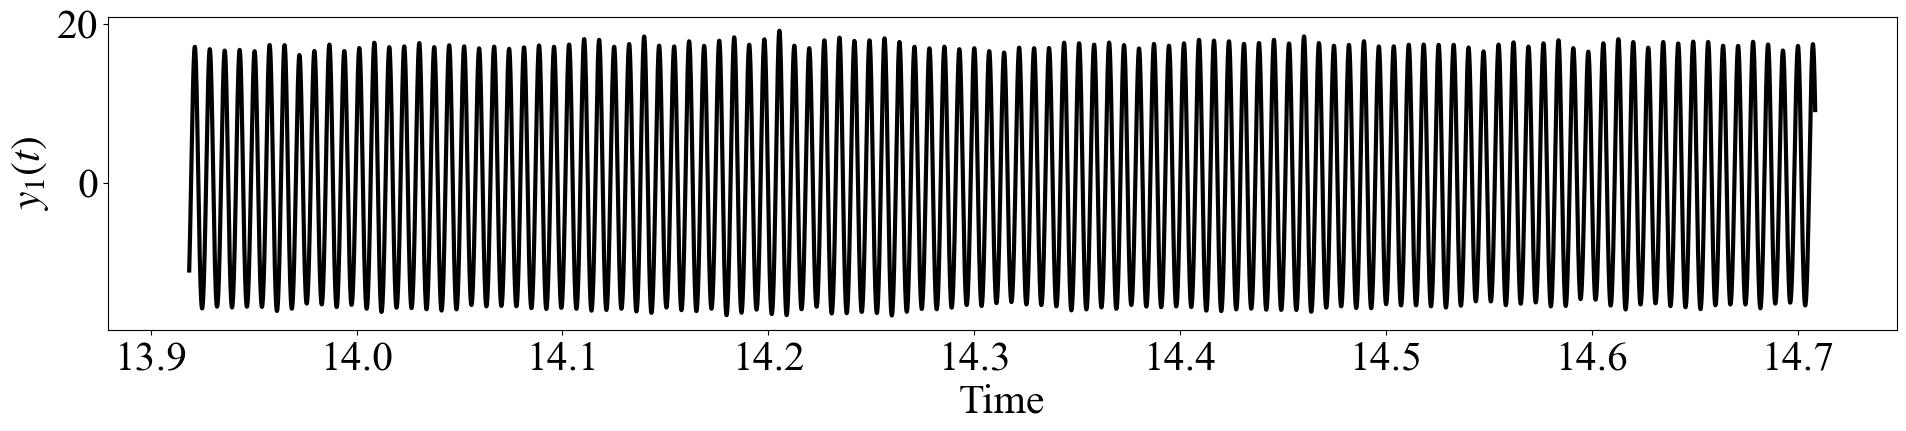

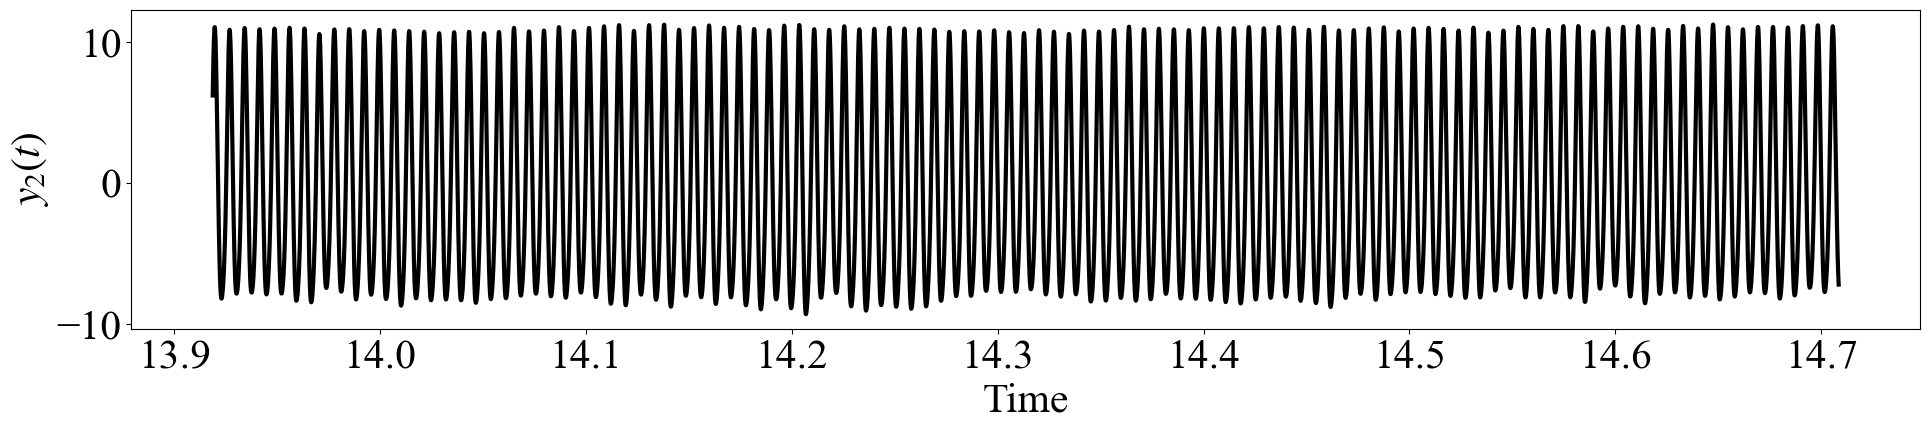

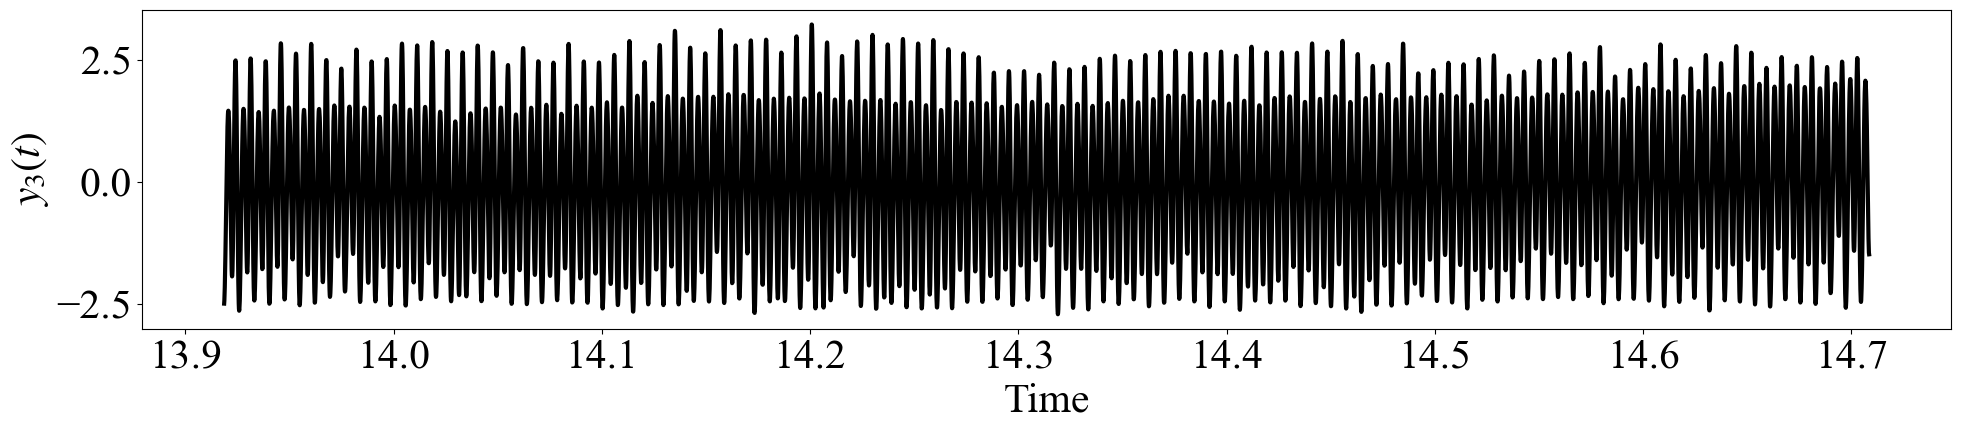

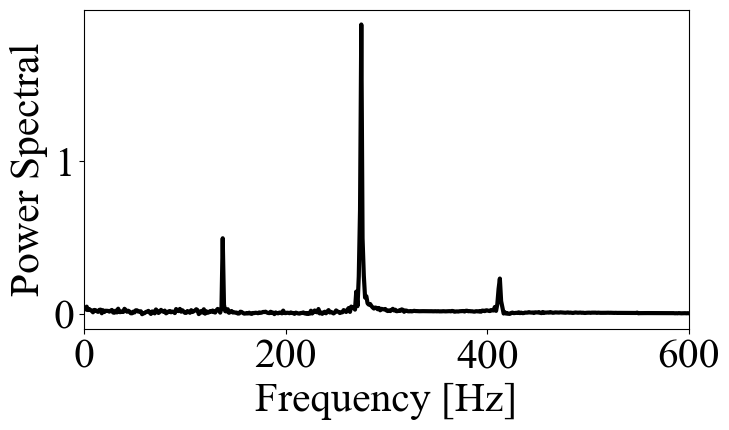

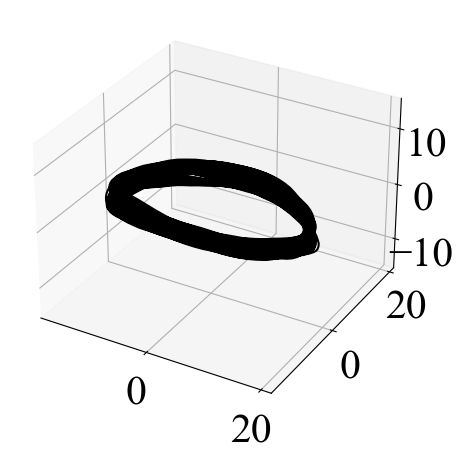

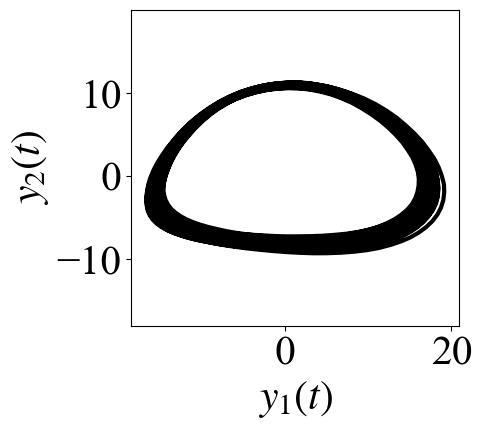

In [149]:
fig = Figure({
            'font.family':'Times New Roman',
            'mathtext.fontset':'stix',
            'font.size':30,
            })

fig.timeseries(data=latent_vector_fvf[:, 0], t=video_fvf_t_data, start=50, stop=-50,
                figsize=(20, 5), linestyle='-', c='k', lw='3',
                title=None, title_loc='center', 
                xlabel='Time', ylabel=r'$y_1(t)$',
                save_png=None, save_eps=None)
fig.timeseries(data=latent_vector_fvf[:, 1], t=video_fvf_t_data, start=50, stop=-50,
                figsize=(20, 5), linestyle='-', c='k', lw='3',
                title=None, title_loc='center', 
                xlabel='Time', ylabel=r'$y_2(t)$',
                save_png=None, save_eps=None)
fig.timeseries(data=latent_vector_fvf[:, 2], t=video_fvf_t_data, start=50, stop=-50,
                figsize=(20, 5), linestyle='-', c='k', lw='3',
                title=None, title_loc='center', 
                xlabel='Time', ylabel=r'$y_3(t)$',
                save_png=None, save_eps=None)  

fig.power_spectra(data=latent_vector_fvf[:, 2], t=video_fvf_t_data, freq_lim=(0, 600),
                figsize=(8, 5), linestyle='-', c='k', lw='3',
                title=None, title_loc='center', 
                xlabel='Frequency [Hz]', ylabel='Power Spectral',
                save_png=None, save_eps=None)  

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(projection='3d')
ax.plot(latent_vector_fvf[50:-50, 0], latent_vector_fvf[50:-50, 1], latent_vector_vf[50:-50, 2], c='k')
ax.set_aspect('equal', 'datalim')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(5.5, 5))
ax = fig.add_subplot()
ax.plot(latent_vector_fvf[50:-50, 0], latent_vector_fvf[50:-50, 1], c='k', lw=3)
ax.set_xlabel(r'$y_1(t)$')
ax.set_ylabel(r'$y_2(t)$')
ax.set_aspect('equal', 'datalim')
plt.tight_layout()
plt.show() 



In [113]:
import pysindy as ps
train_X = latent_vector_fvf[50:-50, :2]
train_t = video_fvf_t_data[50:-50]
train_dX = ps.SmoothedFiniteDifference(smoother_kws={'window_length': 5, 'polyorder': 3})._differentiate(x=train_X, t=train_t)
model = ps.SINDy(
                feature_names=['y1', 'y2'], 
                optimizer=ps.STLSQ(threshold=4), 
                feature_library=ps.PolynomialLibrary(degree=3), 
                )
model.fit(x=train_X, 
        t=train_t,  
        x_dot=train_dX)
model.print()

(y1)' = -2697.068 1 + -58.076 y1 + 1522.779 y2 + 19.372 y1^2 + 6.669 y1 y2
(y2)' = -105.073 1 + -518.845 y1 + 44.756 y2 + -32.147 y1 y2 + 4.970 y2^2


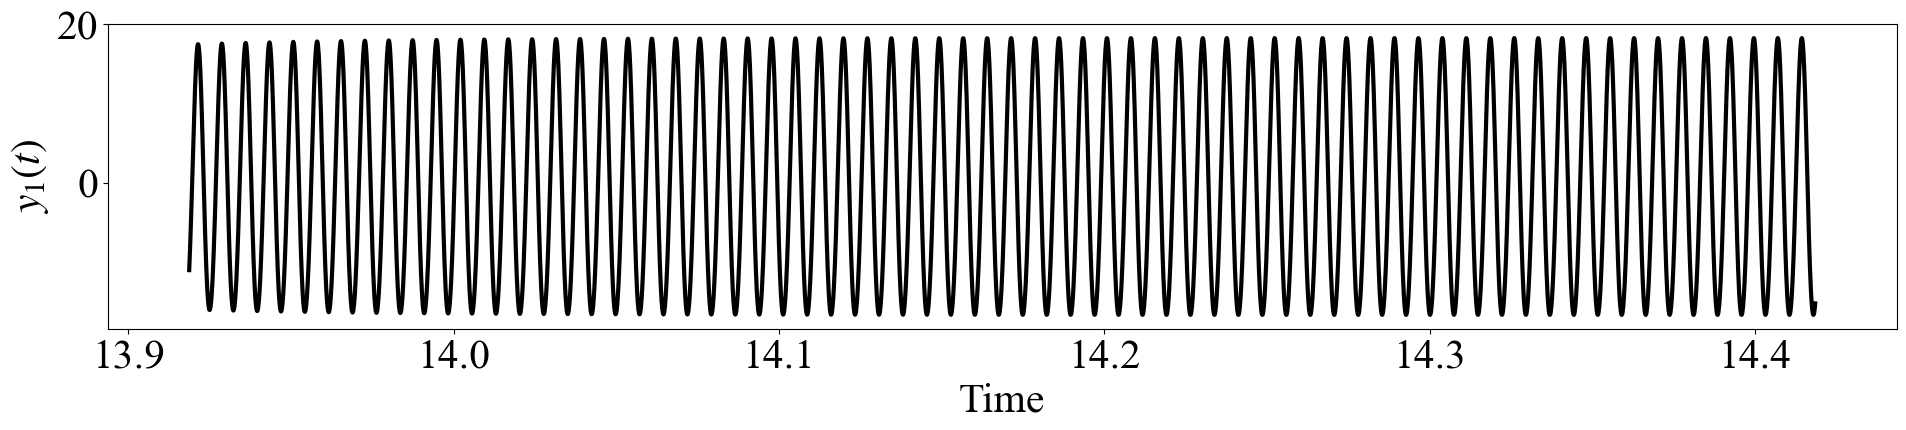

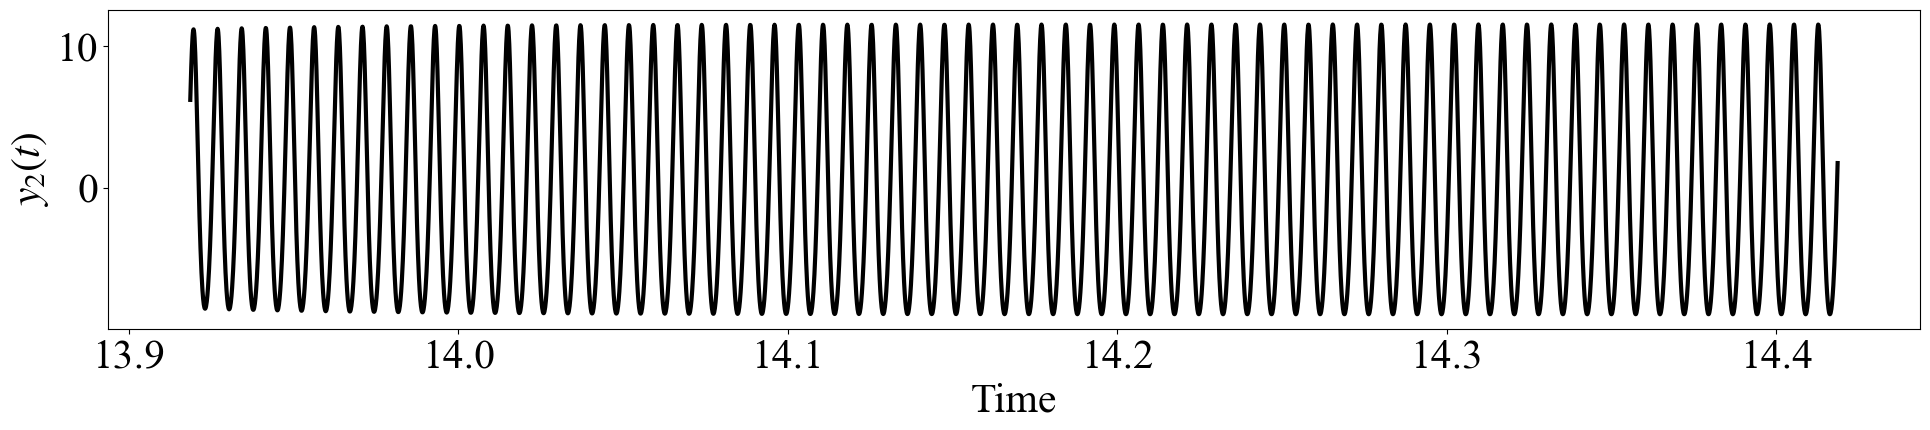

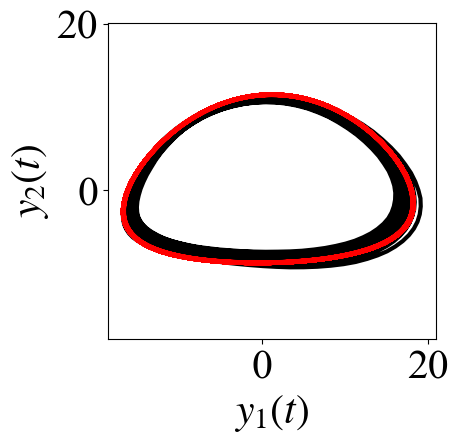

In [115]:
n_run = 5000
pred_train_X = model.simulate(train_X[0, :], train_t[:n_run])
pred_train_X.shape

fig = Figure({
            'font.family':'Times New Roman',
            'mathtext.fontset':'stix',
            'font.size':30,
            })
fig.timeseries(data=pred_train_X[:, 0], t=train_t[:n_run], start=0, stop=None,
                figsize=(20, 5), linestyle='-', c='k', lw='3',
                title=None, title_loc='center', 
                xlabel='Time', ylabel=r'$y_1(t)$',
                save_png=None, save_eps=None)
fig.timeseries(data=pred_train_X[:, 1], t=train_t[:n_run], start=0, stop=None,
                figsize=(20, 5), linestyle='-', c='k', lw='3',
                title=None, title_loc='center', 
                xlabel='Time', ylabel=r'$y_2(t)$',
                save_png=None, save_eps=None)                

fig = plt.figure(figsize=(5.5, 5))
ax = fig.add_subplot()
ax.plot(train_X[:n_run, 0], train_X[:n_run, 1], c='k', lw=3)
ax.plot(pred_train_X[1000:, 0], pred_train_X[1000:, 1], c='r', lw=3)
ax.set_xlabel(r'$y_1(t)$')
ax.set_ylabel(r'$y_2(t)$')
ax.set_aspect('equal', 'datalim')
plt.tight_layout()
plt.show()

In [118]:
np.concatenate([latent_vector_vf[50:-50, :2], latent_vector_fvf[50:-50, :2]], 1).shape

(7899, 4)

In [140]:
import pysindy as ps
train_X = np.concatenate([latent_vector_vf[50:-50, :2], latent_vector_fvf[50:-50, :2]], 1)
train_t = video_vf_t_data[50:-50]
train_dX = ps.SmoothedFiniteDifference(smoother_kws={'window_length': 5, 'polyorder': 3})._differentiate(x=train_X, t=train_t)
model = ps.SINDy(
                feature_names=['vf1', 'vf2', 'fvf1', 'fvf2'], 
                optimizer=ps.STLSQ(threshold=4), 
                feature_library=ps.PolynomialLibrary(degree=3), 
                )
model.fit(x=train_X, 
        t=train_t,  
        x_dot=train_dX)
model.print()

(vf1)' = 478.053 1 + 11.295 vf1 + -2821.106 vf2 + -7.232 vf1^2 + 5.506 vf1^2 vf2 + 25.117 vf2^3
(vf2)' = -449.209 1 + 398.254 vf1 + -16.094 vf2 + 5.180 vf1^2 + 17.846 vf1 vf2
(fvf1)' = -2697.068 1 + -58.076 fvf1 + 1522.779 fvf2 + 19.372 fvf1^2 + 6.669 fvf1 fvf2
(fvf2)' = -99.589 1 + -6.970 vf1 + -4.693 vf2 + -516.591 fvf1 + 50.803 fvf2 + -32.183 fvf1 fvf2 + 4.844 fvf2^2


memo:

声帯・仮声帯を2つの振動子が結合したシステムとした場合の支配方程式は、それぞれを単体のシステムとして推定した支配方程式と類似した関数の組み合わせが見られた。結合部分は仮声帯第２主成分の方程式のみに見られ、仮声帯の振動が声帯の影響を受けていることが考えられる。

相互作用が全く無いデータ・弱い相互作用のデータ・強い相互作用のデータがあれば、それぞれから推定される方程式から相互作用を定量的に評価できるかもしれない。

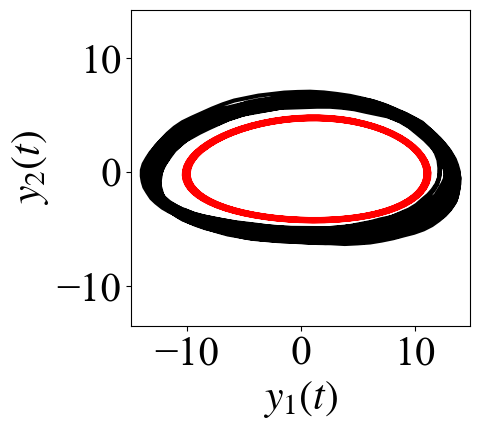

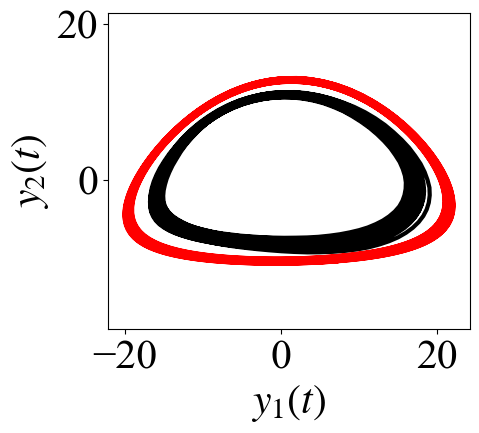

In [141]:
n_run = 5000
pred_train_X = model.simulate(train_X[0, :], train_t[:n_run])
pred_train_X.shape

fig = plt.figure(figsize=(5.5, 5))
ax = fig.add_subplot()
ax.plot(train_X[:n_run, 0], train_X[:n_run, 1], c='k', lw=3)
ax.plot(pred_train_X[4000:, 0], pred_train_X[4000:, 1], c='r', lw=3)
ax.set_xlabel(r'$y_1(t)$')
ax.set_ylabel(r'$y_2(t)$')
ax.set_aspect('equal', 'datalim')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(5.5, 5))
ax = fig.add_subplot()
ax.plot(train_X[:n_run, 2], train_X[:n_run, 3], c='k', lw=3)
ax.plot(pred_train_X[4000:, 2], pred_train_X[4000:, 3], c='r', lw=3)
ax.set_xlabel(r'$y_1(t)$')
ax.set_ylabel(r'$y_2(t)$')
ax.set_aspect('equal', 'datalim')
plt.tight_layout()
plt.show()